# Deep Q-Learning algorithm

In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import tf_agents as tf_ag
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec, tensor_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import policy_step as ps
from tf_agents.typing import types
from tf_agents.policies import random_py_policy
from tf_agents.policies import epsilon_greedy_policy
from tf_agents.policies import random_tf_policy
from tf_agents.policies import py_policy
from tf_agents.metrics import py_metrics
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import py_driver
from tf_agents.drivers import tf_driver
from tf_agents.drivers import dynamic_episode_driver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver
from tf_agents.policies import py_tf_eager_policy

import matplotlib.pyplot as plt
import qutip
from qutip import sigmap, expect

import random

import sys
sys.path.append('../')
from common.common import get_average_return
from TD_algorithms import Dqn

%matplotlib inline

* System parameters

In [8]:
T = 3.5 # terminal time step
max_steps = 30 # number of time steps
nb_iterations = 2000
fc_layer_params = ((100, 75))

seed = 1989
tf.random.set_seed(seed)

checkpoint_dir = "../checkpoints/DQN_continuous_state_e-4_error/"
policy_dir = "../saved_policies/DQN_continuous_e-4_error/"

* Create training and evaluation environments and define actions

In [9]:
# validate environment
from environments.qubit_env import QubitStateContEnv

# define actions
# TODO: actions can be continuous within a range of course 
# actions will be the change in the magnetic field
max_Ω = 1

nb_actions = 9
zero_action = np.array(0, dtype = np.float32) # action 0
plus_action = np.array(max_Ω, dtype = np.float32) # action 1
minus_action = np.array(-max_Ω, dtype = np.float32) # action 2
half_plus_action = np.array(max_Ω / 2, dtype = np.float32) # action 3
half_minus_action = np.array(-max_Ω / 2, dtype = np.float32) # action 5
quarter_plus_action = np.array(max_Ω / 4, dtype = np.float32) # action 6
quarter_minus_action = np.array(-max_Ω / 4, dtype = np.float32) # action 7
plus2_action = np.array(2 * max_Ω, dtype = np.float32) # action 8
minus2_action = np.array(-2 * max_Ω, dtype = np.float32) # action 9

actions = [quarter_plus_action, quarter_minus_action, half_plus_action, half_minus_action, zero_action, plus_action, minus_action, plus2_action, minus2_action]

# shuffle them randomly to avoid bias
random.shuffle(actions)

# list of possible Rabi frequency values
omegas = [-max_Ω, -3 * max_Ω / 4, -max_Ω / 4, -max_Ω / 2, 0, max_Ω / 2, max_Ω / 4, 3 * max_Ω / 4, max_Ω]

environment = QubitStateContEnv(T, max_steps, max_Ω, actions, fidelity_threshold = 0.9999, verbose_fg = False, nb_actions = nb_actions)
eval_environement = QubitStateContEnv(T, max_steps, max_Ω, actions, fidelity_threshold = 0.9999, verbose_fg = False, nb_actions = nb_actions)

In [10]:
agent, q_net, replay_buffer, avg_returns = Dqn(
    environment, 
    eval_environement, 
    nb_iterations = nb_iterations, 
    learning_rate = 1e-3, 
    gamma = 0.99, 
    max_steps = max_steps, 
    epsilon_greedy = 0.1,
    fc_layer_params = fc_layer_params,
    # checkpoint_dir = checkpoint_dir
)

step = 50: loss = 0.1535096913576126
step = 100: loss = 3.112163543701172
step = 150: loss = 2.429961919784546
step = 200: loss = 1.3703700304031372
step = 250: loss = 1.1264482736587524
step = 300: loss = 0.22714008390903473
step = 350: loss = 2.205005645751953
step = 400: loss = 0.47095298767089844
step = 450: loss = 0.9362993240356445
step = 500: loss = 0.9317036867141724
step = 550: loss = 0.7869590520858765
step = 600: loss = 0.6892964839935303
step = 650: loss = 1.374028205871582
step = 700: loss = 1.0011428594589233
step = 750: loss = 1.2424033880233765
step = 800: loss = 1.3964383602142334
step = 850: loss = 0.41256213188171387
step = 900: loss = 0.06400485336780548
step = 950: loss = 1.168518304824829
step = 1000: loss = 2.2105705738067627
step = 1050: loss = 0.3733748197555542
step = 1100: loss = 0.24724897742271423
step = 1150: loss = 0.38263243436813354
step = 1200: loss = 0.44637009501457214
step = 1250: loss = 0.9637762308120728
step = 1300: loss = 0.5351076722145081
step

In [11]:
def extract_policy(agent):
    greedy_actions = []
    optimal_omegas = []
    states = []
    fidelities = []
    t, Ω = (0, 0)
    optimal_policy = agent.policy

    environment.reset()
    tf_env = tf_py_environment.TFPyEnvironment(environment)
    time_step = tf_env.reset()

    states.append(environment._quantum_state)
    fidelities.append(0.0)
    
    while t < max_steps: #and tf_env._episode_ended is False:
        # get initial state (t, Ω)
        omega_index = omegas.index(Ω)
        
        # select maximum value action
        # use a neural network to get the estimate for the best action 
        # get the argmax of the action with the highest value
        action_tensor = optimal_policy.action(time_step)
        [action_index] = action_tensor[0].numpy()

        # add action into array of actions
        greedy_actions.append(action_index)

        # get actual action from index
        action = actions[action_index]

        # apply action into the environment
        time_step = tf_env.step(action_index)

        states.append(environment._quantum_state)

        # get the new state/observation after tha action
        [[Ω, _, _, _]] = time_step.observation.numpy()

        # apply field in tha array
        optimal_omegas.append(Ω)

        fidelities.append(environment._fidelity ** 2)

        if environment._episode_ended:
            break
        
    return (greedy_actions, optimal_omegas, states, fidelities)

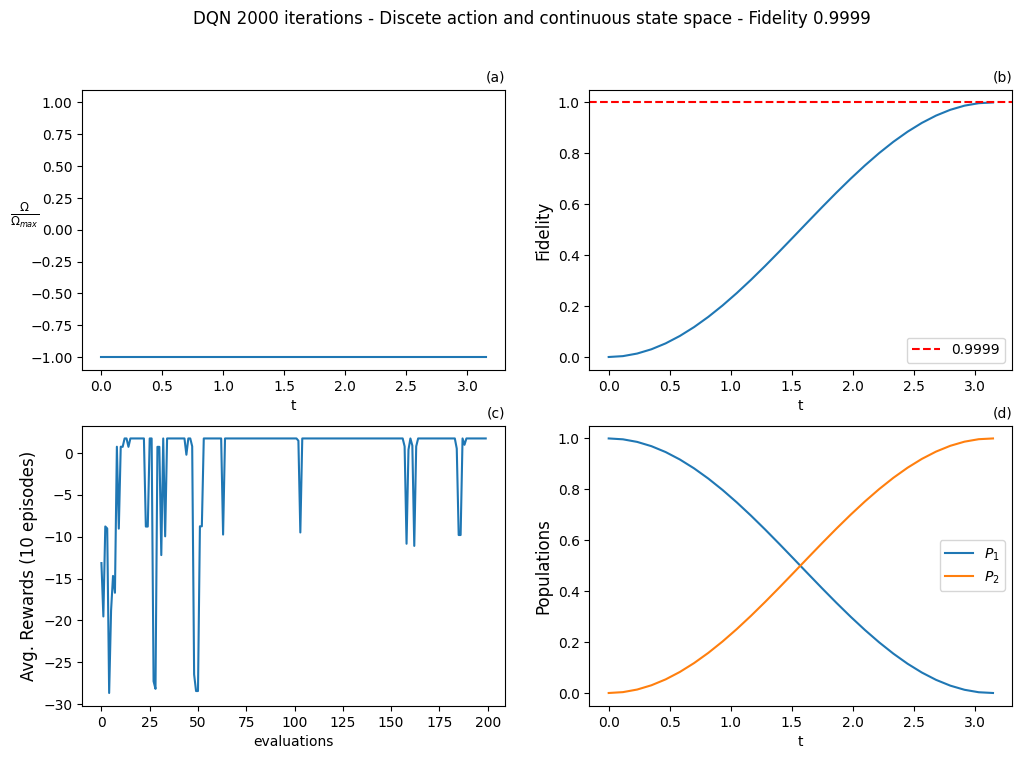

In [13]:
greedy_actions, optimal_omegas, states, fidelities = extract_policy(agent)

# append another omega so that the last step can be shown in the figure
optimal_omegas.append(optimal_omegas[-1])

population2 = expect(sigmap().dag() * sigmap(), states)
population1 = 1 - population2

time_span = np.arange(len(optimal_omegas))
time_span = [t * T / max_steps for t in time_span]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figheight(8)
fig.set_figwidth(12)
fig.suptitle(f'DQN {nb_iterations} iterations - Discete action and continuous state space - Fidelity 0.9999')

ax1.step(time_span, optimal_omegas, where = 'post')
ax1.set_ylabel(r"$\frac{\Omega}{\Omega_{max}}$", rotation = 0, fontsize = 12)
ax1.set_ylim((-1.1, 1.1))
ax1.set_xlabel(f"t")
ax1.set_title("(a)", loc = "right", fontsize = 10)

ax2.plot(time_span, fidelities)
ax2.axhline(y = 0.9999, color = 'r', linestyle = '--', label = '0.9999')
ax2.set_ylabel("Fidelity", rotation = 90, fontsize = 12)
ax2.set_xlabel(f"t")
ax2.legend(loc = 'lower right')
ax2.set_title("(b)", loc = "right", fontsize = 10)

ax4.plot(time_span, population1, label = r"$P_1$")
ax4.plot(time_span, population2, label = r"$P_2$")
ax4.set_ylabel("Populations", rotation = 90, fontsize = 12)
ax4.set_xlabel(f"t")
ax4.set_title("(d)", loc = "right", fontsize = 10)
ax4.legend()

time_span3 = range(len(avg_returns))
ax3.plot(time_span3, avg_returns)
ax3.set_ylabel("Avg. Rewards (10 episodes)", rotation = 90, fontsize = 12)
ax3.set_xlabel(f"evaluations")
ax3.set_title("(c)", loc = "right", fontsize = 10)
plt.show()